## Open-set in Imagenet Paper
This notebook contains the code to reproduce the figures in the paper. 
### OSCR Curves for all protocols


In [1]:
import numpy as np
import pandas as pd

def get_models_epochs(file_dict):
    row = []
    for alias, file_path in file_dict.items():
        folder = str(file_path).split('/')[:-1]
        ckp1 = '/'.join(folder)+'/'+folder[-1]+'_best.pth'
        if alias == "$S_2$":
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_119.pth'
        else:
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_curr.pth'
        epoch1 = util.get_checkpoint_epoch(ckp1)
        epoch2 = util.get_checkpoint_epoch(ckp2)
        row.append((alias, epoch1, epoch2))
    return pd.DataFrame(row, columns =['Name', 'best', 'curr'])


def get_confidence(scores, targets):
    targets = targets.astype(int)
    kn = targets >= 0
    ku = targets == -1
    uu = targets == -2
    C = scores.shape[1]
    weights = np.array([sum(kn), sum(ku), sum(uu)])/C
    ckk = np.mean(scores[kn,targets[kn]])
    cku = np.mean(1 - np.amax(scores[ku], axis=1) + 1/C)
    
    if sum(uu) != 0:
        cuu = np.mean(1 - np.amax(scores[uu], axis=1) + 1/C)
        c_mean = np.average(np.array([ckk, cku, cuu]), weights=weights)
    else:
        c_mean = np.average(np.array([ckk, cku]), weights=weights[:-1])
        cuu = -1
    return ckk, cku, cuu, c_mean

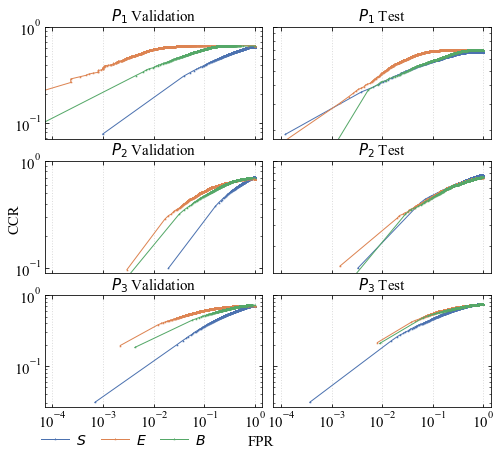

In [28]:
import sys
sys.path.append("../")
import src.util as util
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["font.family"] = "Times New Roman"

# General Experiments
results = Path('../../results')
outputs = Path('../outputs/')
old = Path('../outputs/old')

p1_paths = {
    '$S_{1}$':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_val_arr.npz',
    '$E_{1}$':    outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_val_arr.npz',
    '$B_{1}$':    outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_val_arr.npz',
    }

p2_paths = {    
    '$S_{2}$':  outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_val_arr.npz',
    '$E_{2}$':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_val_arr.npz',
    '$B_{2}$':  outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_val_arr.npz',
    }

p3_paths = {    
    '$S_{3}$':  outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_val_arr.npz',
    '$E_{3}$':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_val_arr.npz',    
    '$B_{3}$':  outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_val_arr.npz',
   }

p1_val = util.read_array_list(p1_paths)
p1_test = util.read_array_list(util.transform_to_test(p1_paths))

p2_val = util.read_array_list(p2_paths)
p2_test = util.read_array_list(util.transform_to_test(p2_paths))

p3_val = util.read_array_list(p3_paths)
p3_test = util.read_array_list(util.transform_to_test(p3_paths))

points = 1000
font = 15
scale = 'log'
fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.05)
axs = gs.subplots(sharex=True, sharey=False)
axs = axs.flat

ax = util.plot_oscr(arrays=p1_val, scale=scale, title='$P_1$ Validation', ax_label_font=font, ax=axs[0], legend_pos="no", unk_label=-1, points=points)
ax = util.plot_oscr(arrays=p1_test, scale=scale, title='$P_1$ Test', ax_label_font=font, ax=axs[1], legend_pos="no", unk_label=-2, points=points)
ax = util.plot_oscr(arrays=p2_val, scale=scale, title='$P_2$ Validation', ax_label_font=font, ax=axs[2], legend_pos="no", unk_label=-1, points=points)
ax = util.plot_oscr(arrays=p2_test, scale=scale, title='$P_2$ Test', ax_label_font=font, ax=axs[3], legend_pos="no", unk_label=-2, points=points)
ax = util.plot_oscr(arrays=p3_val, scale=scale, title='$P_3$ Validation', ax_label_font=font, ax=axs[4], legend_pos="no", unk_label=-1, points=points)
util.plot_oscr(arrays=p3_test, scale=scale, title='$P_3$ Test', ax_label_font=font, ax=axs[5], legend_pos="no", unk_label=-2, points=points)
# Manual legend
ax.legend(['$S$', '$E$', '$B$'], frameon=False, fontsize=font - 1, bbox_to_anchor=(0.8, -0.12), ncol=3, handletextpad=0.5, columnspacing=1)
# Axis properties
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
# Figure labels
fig.text(0.5, 0.05, 'FPR', ha='center', fontsize=font)
fig.text(0.06, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

plt.savefig('fig/oscr_all_protocols.pdf', dpi=90, bbox_inches='tight', pad_inches = 0)
plt.show()

### Confidence Metrics

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator

plt.rcParams["font.family"] = "Times New Roman"

outputs = Path('../outputs/')
event_paths = {    
    '$E_{1}$':  outputs / 'e1n_l1_e0_adam/events.out.tfevents.1655681577.rolf.252847.0',    
    '$B_{1}$':  outputs / 'b1n_l1_e0_adam/events.out.tfevents.1655681314.rolf.247397.0',
    '$E_{2}$':  outputs / 'e2n_l1_e0_adam/events.out.tfevents.1655681413.rolf.249030.0',
    '$B_{2}$':  outputs / 'b2n_l1_e0_adam/events.out.tfevents.1655681057.rolf.239916.0',
    '$E_{3}$':  outputs / 'e3n_l1_e0_adam/events.out.tfevents.1655711400.rolf.249245.0',
    '$B_{3}$':  outputs / 'b3n_l1_e0_adam/events.out.tfevents.1655681621.rolf.253932.0',}
exp_paths = {
    '$S_{1}$':  outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_val_arr.npz',
    '$E_{1}$':  outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_val_arr.npz',
    '$B_{1}$':  outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_val_arr.npz',
    '$S_{2}$':  outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_val_arr.npz',
    '$E_{2}$':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_val_arr.npz',
    '$B_{2}$':  outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_val_arr.npz',
    '$S_{3}$':  outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_val_arr.npz',
    '$E_{3}$':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_val_arr.npz',
    '$B_{3}$':  outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_val_arr.npz',}

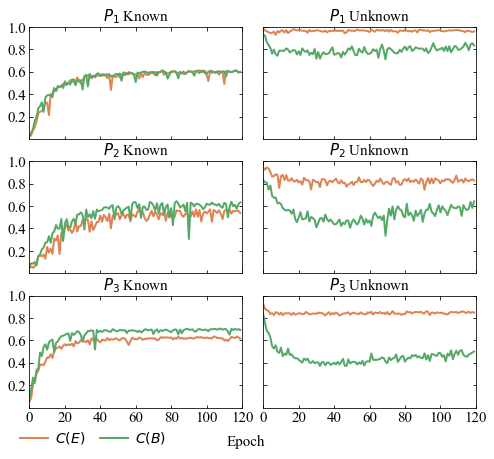

In [25]:
linewidth = 2
legend_pos = "lower right"
font_size = 15
colors = sns.color_palette("deep")
colors2 = sns.color_palette("deep")
fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

for ix, (exp_name, f_path)  in enumerate(event_paths.items()):  
    ax_kn = axs[2 * (ix//2)]
    ax_unk = axs[2 * (ix//2) + 1]
    # Read data from the tensorboard object  
    event_acc = EventAccumulator(str(f_path), size_guidance={'scalars': 0})
    event_acc.Reload()
    # Plot known confidence
    _, step_kn, val_kn = zip(*event_acc.Scalars('val/conf_kn'))
    ax_kn.plot(step_kn, val_kn, linewidth=linewidth, label = exp_name + ' kn', color=colors[ix%2 + 1])
    # Plot unknown confidence
    _, step_unk, val_unk = zip(*event_acc.Scalars('val/conf_unk'))
    ax_unk.plot(step_unk, val_unk, linewidth=linewidth, label = exp_name + ' unk', color=colors2[ix%2 + 1], )
    #  set axis properties
    ax_kn.set_title("$P_{}$ Known".format(ix//2 + 1), fontsize=font_size)
    ax_unk.set_title("$P_{}$ Unknown".format(ix//2 + 1), fontsize=font_size)

# Manual legend
axs[-2].legend(['$C(E)$', '$C(B)$'], frameon=False, fontsize=font_size - 1, bbox_to_anchor=(0.7, -0.09), ncol=2, handletextpad=0.5, columnspacing=1)

for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, labelsize=font_size)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 1)
    # Thicklocator parameters
    ax.yaxis.set_major_locator(MaxNLocator(5, prune='lower'))
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.label_outer()
# X label
fig.text(0.5, 0.05, 'Epoch', ha='center', fontsize=font_size)
plt.savefig('fig/confidence.pdf', dpi=90, bbox_inches='tight', pad_inches = 0)
plt.show()

In [64]:
# Get the confidence of the correctly classified samples
threshold = 0.5
experiments = util.read_array_list(exp_paths)

for exp_name, exp_array in experiments.items():
    gt = exp_array['gt'].astype(int)
    scores = exp_array['scores']
    if exp_name.startswith("$B"):
        scores = scores[:, :-1]
        
    kn = gt >= 0
    pred_class = np.argmax(scores, axis=1)
    gt_score = scores[range(len(scores)), gt]
    
    correct = (gt == pred_class) * ( gt_score >= threshold)
    conf_correct = np.sum(gt_score[correct]) / sum(correct)
    
    conf_kn = np.sum(gt_score[kn]) / sum(kn)
    print(exp_name, 'len_samples', gt.shape, 'len_correct', sum(correct),
          "conf_correct {:.3f}".format(conf_correct),
          "conf_kn {:.2f}".format(conf_kn))


$S_{1}$ len_samples (46481,) len_correct 17709 conf_correct 0.949 conf_kn 0.61
$E_{1}$ len_samples (46481,) len_correct 17359 conf_correct 0.935 conf_kn 0.60
$B_{1}$ len_samples (46481,) len_correct 17794 conf_correct 0.948 conf_kn 0.61
$S_{2}$ len_samples (15178,) len_correct 5371 conf_correct 0.954 conf_kn 0.69
$E_{2}$ len_samples (15178,) len_correct 4294 conf_correct 0.941 conf_kn 0.57
$B_{2}$ len_samples (15178,) len_correct 4935 conf_correct 0.950 conf_kn 0.63
$S_{3}$ len_samples (63764,) len_correct 25949 conf_correct 0.914 conf_kn 0.66
$E_{3}$ len_samples (63764,) len_correct 24420 conf_correct 0.954 conf_kn 0.63
$B_{3}$ len_samples (63764,) len_correct 27250 conf_correct 0.963 conf_kn 0.70


### Histograms

In [26]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from matplotlib.ticker import LogLocator
import src.util as util
plt.rcParams["font.family"] = "Times New Roman"

# General Experiments
outputs = Path('../outputs/')
exp_paths = {
    '$S_{1}$':  outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_val_arr.npz',
    '$E_{1}$':  outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_val_arr.npz',
    '$B_{1}$':  outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_val_arr.npz',
    '$S_{2}$':  outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_val_arr.npz',
    '$E_{2}$':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_val_arr.npz',
    '$B_{2}$':  outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_val_arr.npz',
    '$S_{3}$':  outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_val_arr.npz',
    '$E_{3}$':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_val_arr.npz',
    '$B_{3}$':  outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_val_arr.npz',}

def get_histogram(array, unk_label=-1, metric='score', bins=100, drop_bg=False, log_space=False):
    score = array['scores']
    if drop_bg:
        score = score[:,:-1]
    gt = array['gt'].astype(np.int64)
    features = array['features']
    norms = np.linalg.norm(features, axis=1)
    kn = (gt >= 0)
    unk = gt == unk_label
    if metric == 'score':
        kn_metric = score[kn, gt[kn]]
        unk_metric = np.amax(score[unk], axis=1)
    elif metric == 'norm':
        kn_metric = norms[kn]
        unk_metric = norms[unk]
    if log_space:
        bins = np.geomspace(1, 1e2, num=bins)
    kn_hist, kn_edges = np.histogram(kn_metric, bins=bins)
    unk_hist, unk_edges = np.histogram(unk_metric, bins=bins)
    return kn_hist, kn_edges, unk_hist, unk_edges

### Softmax scores

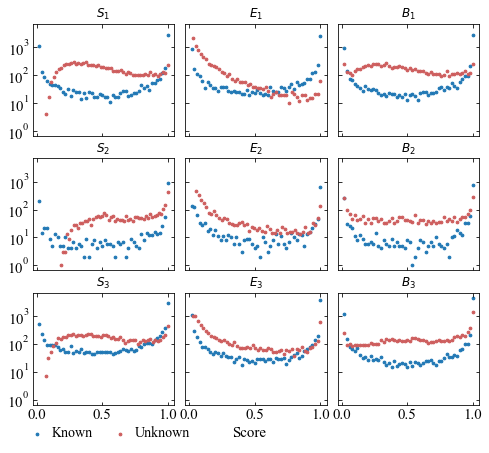

In [27]:
# exp_val = util.read_array_list(exp_paths)
exp_val = util.read_array_list(util.transform_to_test(exp_paths))

font_size = 15
bins = 50
unk_label = -2

fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 3, hspace=0.2, wspace=0.08)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
    
for ix, (exp_name, exp_array) in enumerate(exp_val.items()):
    # Calculate histogram
    drop_bg = True if exp_name.startswith("$B") else False  #  Drop the background class
    kn_hist, kn_edges, unk_hist, unk_edges = get_histogram(exp_array, unk_label=unk_label, metric='score', bins=bins, drop_bg=drop_bg)
    # Scatter plots
    axs[ix].scatter(kn_edges[1:], kn_hist, color='tab:blue', marker='.', s=30)
    axs[ix].scatter(unk_edges[1:], unk_hist, color='indianred', marker='.', s=30)
    axs[ix].set_yscale('log')
    axs[ix].set_title(exp_name)
    
for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, labelsize=font_size)
    # Thicklocator parameters
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=6 ))
    ax.label_outer()
    
# Manual legend
axs[-3].legend(['Known', 'Unknown'], frameon=False, fontsize=font_size-1, bbox_to_anchor=(1.2, -0.08), ncol=2, handletextpad=0, columnspacing=1, markerscale=1)
# X label
fig.text(0.5, 0.06, 'Score', ha='center', fontsize=font_size)

plt.savefig('fig/hist_all_score.pdf', dpi=90, bbox_inches='tight', pad_inches = 0)
plt.show()

### Features norms

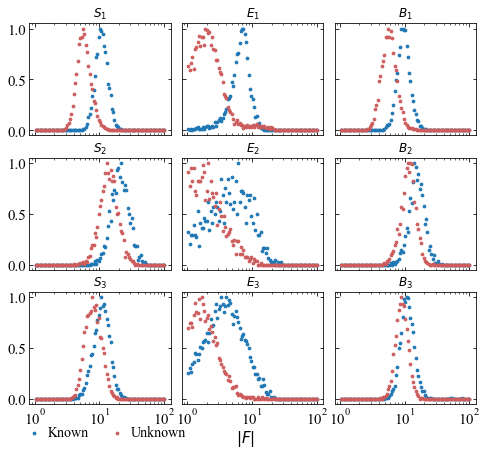

In [28]:
# exp_val = util.read_array_list(exp_paths)
exp_val = util.read_array_list(util.transform_to_test(exp_paths))

font_size = 15
bins = 100
unk_label = -2

fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 3, hspace=0.2, wspace=0.08)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
    
for ix, (exp_name, exp_array) in enumerate(exp_val.items()):
    # Calculate histogram
    kn_hist, kn_edges, unk_hist, unk_edges = get_histogram(exp_array, unk_label=unk_label, metric='norm', bins=bins, log_space=True)
    kn_hist = kn_hist / np.max(kn_hist)
    unk_hist = unk_hist / np.max(unk_hist)
    # Scatter plots
    axs[ix].scatter(kn_edges[1:], kn_hist, color='tab:blue', marker='.', s=30)
    axs[ix].scatter(unk_edges[1:], unk_hist, color='indianred', marker='.', s=30)
    axs[ix].set_xscale('log')
    axs[ix].set_title(exp_name)
    
for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, labelsize=font_size)
    # Thicklocator parameters
    ax.xaxis.set_major_locator(LogLocator(base=10, numticks=6))
    ax.label_outer()
    
# Manual legend
axs[-3].legend(['Known', 'Unknown'], frameon=False, fontsize=font_size-1, bbox_to_anchor=(1.2, -0.08), ncol=2, handletextpad=0, columnspacing=1, markerscale=1)
# X label
fig.text(0.5, 0.05, '$|F|$', ha='center', fontsize=font_size)
plt.savefig('fig/hist_all_norm.pdf', dpi=90, bbox_inches='tight')
plt.show()

In [8]:
from robustness.tools.imagenet_helpers import ImageNetHierarchy, common_superclass_wnid
from pathlib import Path
im_info_path = Path(r"/local/scratch/datasets/ImageNet/ILSVRC2012/robustness")
root_dir = Path(r"/local/scratch/datasets/ImageNet/ILSVRC2012")
hierarchy = ImageNetHierarchy(root_dir, im_info_path)


def get_descendants_wid(hier, node_wn_id, in_imagenet=True):
        if in_imagenet:
            return sorted([ww for ww in hier.tree[node_wn_id].descendants_all
                           if ww in set(hier.in_wnids)])
        else:
            return sorted(list(hier.tree[node_wn_id].descendants_all))
        
def print_parents(tree, wnid):
    parent_id = tree[wnid].parent_wnid
    if parent_id is None:
        return 0
    print(tree[parent_id])
    print_parents(tree, parent_id)    
    
def print_descendants(hier, wid):
    des = get_descendants_wid(hier, wid, False)
    for i in des:
        print(hier.tree[i])


In [12]:
print_descendants(hierarchy, 'n02118333')

Name: (red fox, Vulpes vulpes), ImageNet Class: (277), Descendants: (0)
Name: (kit fox, Vulpes macrotis), ImageNet Class: (278), Descendants: (0)
Name: (Arctic fox, white fox, Alopex lagopus), ImageNet Class: (279), Descendants: (0)
Name: (grey fox, gray fox, Urocyon cinereoargenteus), ImageNet Class: (280), Descendants: (0)


In [11]:
# dog = 'n02084071'
# hun_dog = 'n02087122'

# kn_superclasses = [dog]
# kn_superclasses = ['n02084071', 'n02087122']
# kn_unk_superclasses = ['n02118333', 'n02115335', 'n02114100', 'n02120997',
#                                         'n02131653', 'n02441326', 'n02370806', 'n02469914']
# unk_unk_superclasses = ['n02085374', 'n02118333', 'n02115335', 'n02114100',
#                                          'n02120997', 'n02131653', 'n02441326', 'n02370806']

# print('Known superclass')
# for id in kn_superclasses:
#     print_parents(hierarchy.tree, id)
#     print('\n')
    
print('Kn_unk superclass')
for id in kn_unk_superclasses:
    print_parents(hierarchy.tree, id)
    print('\n')

# print('unk_unk superclass')
# for id in ['n07555863']:
#     print_parents(hierarchy.tree, id)
#     print('\n')

Kn_unk superclass
Name: (canine, canid), ImageNet Class: (-1), Descendants: (12)
Name: (carnivore), ImageNet Class: (-1), Descendants: (35)
Name: (placental, placental mammal, eutherian, eutherian mammal), ImageNet Class: (-1), Descendants: (89)
Name: (mammal, mammalian), ImageNet Class: (-1), Descendants: (95)
Name: (vertebrate, craniate), ImageNet Class: (-1), Descendants: (207)
Name: (chordate), ImageNet Class: (-1), Descendants: (207)
Name: (animal, animate being, beast, brute, creature, fauna), ImageNet Class: (-1), Descendants: (398)
Name: (organism, being), ImageNet Class: (-1), Descendants: (407)
Name: (living thing, animate thing), ImageNet Class: (-1), Descendants: (407)
Name: (whole, unit), ImageNet Class: (-1), Descendants: (936)
Name: (object, physical object), ImageNet Class: (-1), Descendants: (946)
Name: (physical entity), ImageNet Class: (-1), Descendants: (992)
Name: (entity), ImageNet Class: (-1), Descendants: (1000)


Name: (canine, canid), ImageNet Class: (-1), Des